# Wongee Hong, Lennart Vetter, Myisha Hassan

## Project 3: Linear Classification

 - Generate a dataset for yourself consisting of 2 classes from a multivariate normal distribution.
 Mu1 = [1 1], Mu2 = [-1 -1], Sigma = eye(1).
 - Implement two different linear classifiers on this data, a Gaussian generative model, and a logistic regression classifier. For the logistic regression classifier, you must implement the IRLS algorithm.
 - Report your % correct classification (it should be very high for this simple dataset).
 Plot a ROC curve for both of your classifiers, Plot the decision boundary for both your classifiers (hint, it should be a line)
 - Go to Kaggle or the UCI machine learning database, find a dataset that interests you, and try your classifiers on it. Make sure it is a binary dataset with only numerical features.

Created Dataset: Total points: 400, Class 1: 200, Class 2: 200
Gaussian Generative Model Estimated Parameters:
  Weight vector w = [2.08857066 2.14275412]
  Bias term w0 = 0.310
Gaussian Generative Model Accuracy: 92.5%
Logistic Regression Accuracy: 92.5%


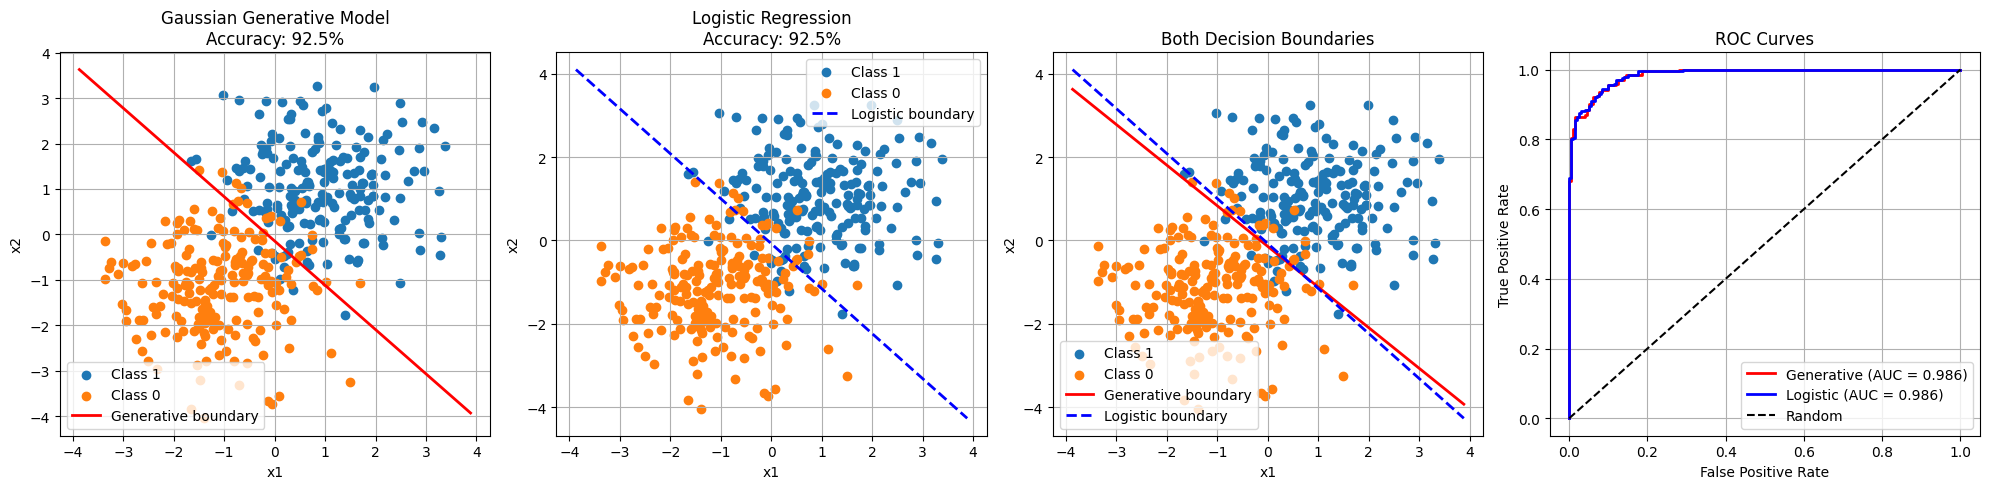

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: create a dataset from multivariate normal distribution

np.random.seed(0)
mu1 = np.array([1, 1])      # Class 1 mean
mu2 = np.array([-1, -1])    # Class 2 mean
Sigma = np.eye(2) # covairance matrix controls spread and orientation of data cloud
# in this case, since sigma = identity matrix -->  forms perfect circle cloud
n_per_class = 200           # Points per class

# Generate Class 1 data (multivariate normal)
# This creates a cloud of points centered at mu1 with shape defined by Sigma
X1 = np.random.multivariate_normal(mean=mu1, cov=Sigma, size=n_per_class) # X1 = N(mu_1, sigma)
t1 = np.ones(n_per_class)  # Labels = 1 for Class 1

# Generate Class 2 data (multivariate normal)
X2 = np.random.multivariate_normal(mean=mu2, cov=Sigma, size=n_per_class)
t2 = np.zeros(n_per_class) # Labels = 0 for Class 2

# Combine both classes into a single dataset for training our classifiers
X = np.vstack([X1, X2])  # Stack all points vertically: 400 total points, each with 2 coordinates
t = np.hstack([t1, t2])  # Combine labels: 400 labels total (200 ones, 200 zeros)
n_total = X.shape[0]     # Total number of data points

print(f"Created Dataset: Total points: {n_total}, Class 1: {n_per_class}, Class 2: {n_per_class}")

#Step 2:Guassian Generative Model Classifier
# This classifier works by modeling each class as a separate Gaussian distribution
# Then we use probability theory (Bayes theorem) to decide which class new points belong to

# First, separate the data by class for parameter estimzation
X_class1 = X[t == 1]  # Extract all points that belong to class 1
X_class2 = X[t == 0]  # Extract all points that belong to class 2
n1 = X_class1.shape[0]  # Count how many points in class 1
n2 = X_class2.shape[0]  # Count how many points in class 2

# Estimate parameters (class prior probabilities) (txtbk eq. 4.73, 4.75-4.80)
pi1 = n1 / n_total # Probability of class 1 = (number of class 1 points) / (total points)
pi2 = n2 / n_total

# Estimate class means --> find the center point of each class by averaging coordinates
mu1_est = np.mean(X_class1, axis=0)  # Average all x,y coordinates for class 1 points
mu2_est = np.mean(X_class2, axis=0)

# Estimate shared covariance matrix (how spread out are the points around their centers) (txtbk eq. 4.78-4.80)
S1 = (X_class1 - mu1_est).T @ (X_class1 - mu1_est) / n1 # Spread of class 1 points
S2 = (X_class2 - mu2_est).T @ (X_class2 - mu2_est) / n2
Sigma_shared = (n1 * S1 + n2 * S2) / n_total # Weighted average of both class spreads

# Linear discriminant parameters which defines decision boundary(textbk eq. 4.66-4.67)
w_gen = np.linalg.solve(Sigma_shared, (mu1_est - mu2_est)) # weight vector that defines the orientation (slop/direction) of the decision boundary
mu1_quad = mu1_est @ np.linalg.solve(Sigma_shared, mu1_est)
mu2_quad = mu2_est @ np.linalg.solve(Sigma_shared, mu2_est)
w0_gen = -0.5 * mu1_quad + 0.5 * mu2_quad + np.log(pi1 / pi2) # bias (intercept) term that shifts the boundary based on class means and priors

print("Gaussian Generative Model Estimated Parameters:")
print(f"  Weight vector w = {w_gen}")
print(f"  Bias term w0 = {w0_gen:.3f}")

def generative_predict(X_points):
    """Compute P(C1|x) using generative model (txtbk eq. 4.65)"""
    linear_score = X_points @ w_gen + w0_gen # how far each point is from the decision boundary
    # Convert linear score to probability using logistic sigmoid
    # Result is between 0 and 1, representing probability of class 1
    return 1 / (1 + np.exp(-linear_score)) # sigmoid

# Make predictions on our training data to see how well we learned
y_gen_proba = generative_predict(X)  # Get probabilities for all points
y_gen_pred = (y_gen_proba > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)
gen_accuracy = np.mean(y_gen_pred == t) * 100 # what percentage of points did we classify correctly?
print(f"Gaussian Generative Model Accuracy: {gen_accuracy:.1f}%")

# Step 3: Logistic Regression Classifier using IRLS
# Logistic regression directly models the probability of each class
# IRLS (Iterative Reweighted Least Squares) finds best parameters

# Create design matrix --> column of 1s to handle the bias term
# This lets us write our model as: probability = sigmoid(Phi * w)
# Where Phi = [1, x1, x2] and w = [w0, w1, w2]
Phi = np.hstack([np.ones((n_total, 1)), X])

# Initialize weights to zeros
w = np.zeros(Phi.shape[1])  # [w0, w1, w2] where w0 is bias, w1,w2 are feature weights

# IRLS algorithm (txtbk Eqs. 4.99-4.100) to iteratively improve weight estimates
n_iterations = 50

for i in range(n_iterations):
    # Step 1: Compute current predictions with current weights
    a = Phi @ w  # Linear combination: a = w0 + w1*x1 + w2*x2
    y_hat = 1 / (1 + np.exp(-a)) # y = sigmoid(a) (predicted probabilities between 0 and 1)

    # Step 2: Compute diagonal weighting matrix R
    # R_nn = y_n(1 - y_n) (txtbk eq. 4.98)
    # R contains variances of our predictions - points near decision boundary get lower weight
    eps = 1e-12  # Small number to avoid division by zero
    r = y_hat * (1 - y_hat)  # Diagonal elements of R

    # Step 3: Compute working response z (txtbk eq. 4.100)
    # z = phi*w_old - R^(-1)(y_hat - t)
    # But since R is diagonal, R^(-1) is element-wise 1/r
    z = a - (y_hat - t) / (r+eps) # creates a "pseudo-target" that linearizes our problem

    # Step 4: Solve weighted least squares (txtbk eq. 4.99)
    # (Phi^T R Phi) w_new = Phi^T R z

    # Weight both sides by sqrt(R) to give more importance to confident predictions
    Phi_weighted = Phi * np.sqrt(r+eps)[:, None]  # Weight each row of Phi datapoints by sqrt(r_n)
    z_weighted = z * np.sqrt(r+eps)               # Weight targets z by sqrt(r_n)

    # Solve the weighted least squares problem
    # (Phi_weighted^T * Phi_weighted) * w_new = Phi_weighted^T * z_weighted
    w = np.linalg.solve(Phi_weighted.T @ Phi_weighted, Phi_weighted.T @ z_weighted) #w_new

# Make final predictions with our trained logistic regression model
y_log_proba = 1 / (1 + np.exp(-Phi @ w))  # Probabilities for all points
y_log_pred = (y_log_proba > 0.5).astype(int)  # Convert to class labels
log_accuracy = np.mean(y_log_pred == t) * 100
print(f"Logistic Regression Accuracy: {log_accuracy:.1f}%")

# Step 4: ROC curves and Decision Boundaries

# ROC curves show how well our classifiers trade off true positives vs false positives
fpr_gen, tpr_gen, _ = roc_curve(t, y_gen_proba)  # Gaussian generative model
fpr_log, tpr_log, _ = roc_curve(t, y_log_proba)  # Logistic regression model
# AUC (Area Under Curve) measures overall performance: 1.0 = perfect, 0.5 = random
auc_gen = auc(fpr_gen, tpr_gen)
auc_log = auc(fpr_log, tpr_log)

# Build x range for line plotting
xmin, xmax = X[:,0].min() - 0.5, X[:,0].max() + 0.5
xline = np.linspace(xmin, xmax, 400)

# Calculate y coordinates for boundaries
# Generative boundary: w1*x1 + w2*x2 + w0 = 0  ->  x2 = (-w1*x1 - w0)/w2
def gg_line(x):
    return (-w_gen[0]*x - w0_gen) / (w_gen[1] + 1e-12)

# Logistic boundary: w0 + w1*x1 + w2*x2 = 0
def lr_line(x, w):
    return ( -w[0] - w[1]*x ) / ( w[2] + 1e-12 )

# Step 5: Plots
plt.figure(figsize=(20, 5))

# (1) Generative model with boundary
plt.subplot(1, 4, 1)
plt.scatter(X1[:,0], X1[:,1], label='Class 1')
plt.scatter(X2[:,0], X2[:,1], label='Class 0')
plt.plot(xline, gg_line(xline), 'r-', lw=2, label='Generative boundary')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title(f'Gaussian Generative Model\nAccuracy: {gen_accuracy:.1f}%')
plt.legend(); plt.grid(True)

# (2) Logistic regression with boundary
plt.subplot(1, 4, 2)
plt.scatter(X1[:,0], X1[:,1], label='Class 1')
plt.scatter(X2[:,0], X2[:,1], label='Class 0')
plt.plot(xline, lr_line(xline, w), 'b--', lw=2, label='Logistic boundary')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title(f'Logistic Regression\nAccuracy: {log_accuracy:.1f}%')
plt.legend(); plt.grid(True)

# (3) Compare Both Decision Boundaries
plt.subplot(1, 4, 3)
plt.scatter(X1[:,0], X1[:,1], label='Class 1')
plt.scatter(X2[:,0], X2[:,1], label='Class 0')
plt.plot(xline, gg_line(xline), 'r-', lw=2, label='Generative boundary')
plt.plot(xline, lr_line(xline, w), 'b--', lw=2, label='Logistic boundary')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Both Decision Boundaries')
plt.legend(); plt.grid(True)

# (4) ROC Curves for Both Classifiers
plt.subplot(1, 4, 4)
plt.plot(fpr_gen, tpr_gen, 'r-', label=f'Generative (AUC = {auc_gen:.3f})', lw=2)
plt.plot(fpr_log, tpr_log, 'b-', label=f'Logistic (AUC = {auc_log:.3f})', lw=2)
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

## Application of Linear Regression to real Dataset

Applies the SAME classifiers on a real (numeric, binary) dataset called "Social Network Ads" from Kaggle.

The datta is freely availabe at: https://www.kaggle.com/datasets/mdwasimakhtar03/social-network-adscsv

To run this script, download and unzip the data and place the .csv into the content folder.

Real dataset loaded: 400 samples, 2 features
Training set: 280 samples
Testing set: 120 samples
  IRLS converged after 7 iterations
Gaussian Generative Model: Accuracy = 81.67%, AUC = 0.921
Logistic Regression: Accuracy = 82.50%, AUC = 0.921


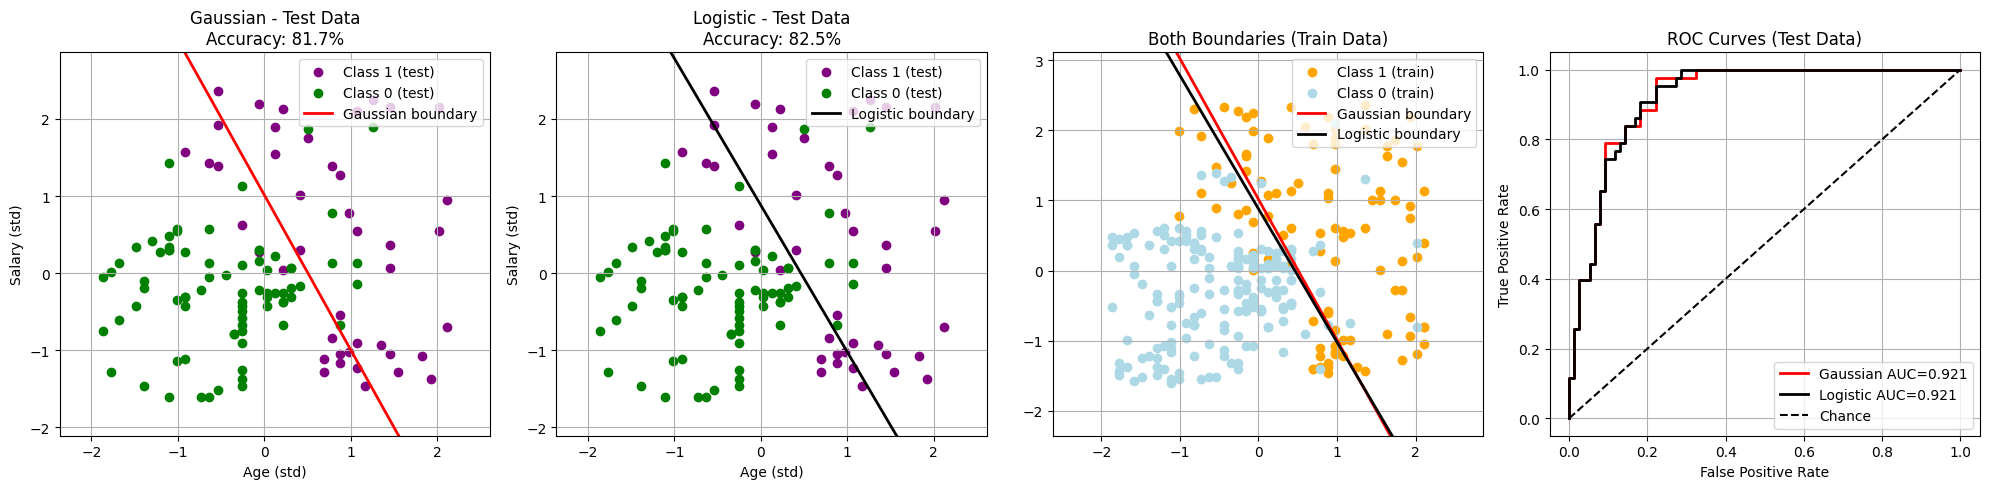

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc

df = pd.read_csv("/content/Social_Network_Ads.csv")
# Extract features (Age and Estimated Salary) and target (Purchased: 0=No, 1=Yes)
Xk = df[['Age', 'EstimatedSalary']].to_numpy(dtype=float)
tk = df['Purchased'].to_numpy(dtype=int)
print(f"Real dataset loaded: {Xk.shape[0]} samples, {Xk.shape[1]} features")

# Split data into training and testing sets
# We train on 70% of data and test on remaining 30% to see how well we generalize
X_train_k, X_test_k, t_train_k, t_test_k = train_test_split(
    Xk, tk, test_size=0.30, random_state=0, stratify=tk)
print(f"Training set: {X_train_k.shape[0]} samples")
print(f"Testing set: {X_test_k.shape[0]} samples")

# Preprocess the data: handle missing values and standardize features
# Fill any missing values with the average value from training set
col_means_k = np.nanmean(X_train_k, axis=0)
X_train_k = np.where(np.isnan(X_train_k), col_means_k, X_train_k)
X_test_k = np.where(np.isnan(X_test_k), col_means_k, X_test_k)

# Standardize: subtract mean and divide by standard deviation
# use training statistics to avoid "cheating" by looking at test data
mu_k = X_train_k.mean(axis=0)  # Mean of each feature in training set
sd_k = X_train_k.std(axis=0) + 1e-12  # Standard deviation of each feature (+ small epsilon)
X_train_k = (X_train_k - mu_k) / sd_k  # Standardize training data
X_test_k = (X_test_k - mu_k) / sd_k    # Standardize test data using training statistics


# A) Apply Gaussian Generative Model to Real Data (TRAIN)

# Separate training data by class to estimate parameters
X1_tr_k = X_train_k[t_train_k == 1]  # Class 1 training points (purchased)
X0_tr_k = X_train_k[t_train_k == 0]  # Class 0 training points (not purchased)
N1k, N0k = len(X1_tr_k), len(X0_tr_k)  # Count samples in each class
Nk = N1k + N0k  # Total training samples

# Estimate class prior probabilities
pi1_k = N1k / Nk  # Probability of purchasing
pi0_k = N0k / Nk  # Probability of not purchasing

# Estimate class means (centers)
mu1_k = X1_tr_k.mean(axis=0)  # Center of purchasing group
mu0_k = X0_tr_k.mean(axis=0)  # Center of non-purchasing group

# Estimate covariance matrices and compute shared covariance
S1_k = np.cov(X1_tr_k, rowvar=False, bias=True)  # Spread of purchasing group
S0_k = np.cov(X0_tr_k, rowvar=False, bias=True)  # Spread of non-purchasing group
Sigma_k = (N1k/Nk)*S1_k + (N0k/Nk)*S0_k  # Weighted average spread

# Compute Gaussian generative model parameters
w_gen_k = np.linalg.solve(Sigma_k, (mu1_k - mu0_k))  # Direction of separation
mu1q_k = mu1_k @ np.linalg.solve(Sigma_k, mu1_k)     # Distance measure for class 1
mu0q_k = mu0_k @ np.linalg.solve(Sigma_k, mu0_k)     # Distance measure for class 0
eps = 1e-12
w0_gen_k = -0.5*mu1q_k + 0.5*mu0q_k + np.log((pi1_k + eps) / (pi0_k + eps)) # Boundary position

# Test posterior & predictions
a_test_gen_k = X_test_k @ w_gen_k + w0_gen_k  # Linear scores for test points
p_test_gen_k = 1/(1+np.exp(-a_test_gen_k))    # Convert to probabilities
y_pred_gen_k = (p_test_gen_k >= 0.5).astype(int)  # Convert to class labels

# B) Logistic Regression via IRLS on TRAIN

# Create design matrices with bias term
Phi_tr_k = np.hstack([np.ones((X_train_k.shape[0], 1)), X_train_k])  # Training: [1, Age, Salary]
Phi_te_k = np.hstack([np.ones((X_test_k.shape[0], 1)), X_test_k])    # Testing: [1, Age, Salary]

# Initialize weights to zeros
w_lr_k = np.zeros(Phi_tr_k.shape[1])

# IRLS algorithm with convergence checking
max_iter, tol, eps = 100, 1e-6, 1e-12

for iteration in range(max_iter):
    # Compute current predictions
    a_k = Phi_tr_k @ w_lr_k
    yhat_k = 1/(1+np.exp(-a_k))
    r_k = yhat_k*(1-yhat_k)
    z_k = a_k - (yhat_k - t_train_k)/(r_k + eps)

    # Solve weighted least squares
    Phi_w_k = Phi_tr_k * np.sqrt(r_k + eps)[:, None]
    z_w_k = z_k * np.sqrt(r_k + eps)
    H_k = Phi_w_k.T @ Phi_w_k
    rhs_k = Phi_w_k.T @ z_w_k
    w_new_k = np.linalg.solve(H_k, rhs_k)

    # Check if weights have converged (stopped changing significantly)
    if np.linalg.norm(w_new_k - w_lr_k) < tol:
        w_lr_k = w_new_k
        print(f"  IRLS converged after {iteration+1} iterations")
        break
    w_lr_k = w_new_k

# Make predictions on test data
p_test_log_k = 1/(1+np.exp(-(Phi_te_k @ w_lr_k)))
y_pred_log_k = (p_test_log_k >= 0.5).astype(int)

# Metrics (TEST) + Plots

# Calculate performance metrics on test data
acc_g_k = 100*accuracy_score(t_test_k, y_pred_gen_k)  # Gaussian generative accuracy
acc_l_k = 100*accuracy_score(t_test_k, y_pred_log_k)  # Logistic regression accuracy
# Compute ROC curves and AUC for test data
fpr_g_k, tpr_g_k, _ = roc_curve(t_test_k, p_test_gen_k)
auc_g_k = auc(fpr_g_k, tpr_g_k)
fpr_l_k, tpr_l_k, _ = roc_curve(t_test_k, p_test_log_k)
auc_l_k = auc(fpr_l_k, tpr_l_k)

print(f"Gaussian Generative Model: Accuracy = {acc_g_k:.2f}%, AUC = {auc_g_k:.3f}")
print(f"Logistic Regression: Accuracy = {acc_l_k:.2f}%, AUC = {auc_l_k:.3f}")

# limits for TRAIN panel
xmin_tr, xmax_tr = X_train_k[:,0].min()-0.75, X_train_k[:,0].max()+0.75
ymin_tr, ymax_tr = X_train_k[:,1].min()-0.75, X_train_k[:,1].max()+0.75

# limits for TEST panel
xmin_te, xmax_te = X_test_k[:,0].min()-0.50, X_test_k[:,0].max()+0.50
ymin_te, ymax_te = X_test_k[:,1].min()-0.50, X_test_k[:,1].max()+0.50

def line_on(ax, wv, w0, xr, label, color):
    """Helper function to plot decision boundary lines"""
    xl, xr_ = xr
    if abs(wv[1]) > 1e-12:  # If we can solve for y
        xs = np.linspace(xl, xr_, 400)
        ys = -(wv[0]*xs + w0) / (wv[1] + 1e-12)
        ax.plot(xs, ys, lw=2, label=label, color=color)
    else:  # Vertical line case
        ax.axvline(-w0/(wv[0]+1e-12), lw=2, label=label, color=color)

# Plot TEST data with boundaries

# Boundaries computed from TRAIN data, plotted with TEST data
xmin_k, xmax_k = X_test_k[:,0].min()-0.5, X_test_k[:,0].max()+0.5
ymin_k, ymax_k = X_test_k[:,1].min()-0.5, X_test_k[:,1].max()+0.5

plt.figure(figsize=(20,5))

# (1) Gaussian Generative boundary on TEST data
ax = plt.subplot(1,4,1)
ax.scatter(X_test_k[t_test_k==1,0], X_test_k[t_test_k==1,1], color='purple', label='Class 1 (test)')
ax.scatter(X_test_k[t_test_k==0,0], X_test_k[t_test_k==0,1], color='green', label='Class 0 (test)')
# plot decision boundary
line_on(ax, w_gen_k, w0_gen_k, (xmin_te, xmax_te), "Gaussian boundary", color='red')
ax.set_xlim(xmin_te, xmax_te); ax.set_ylim(ymin_te, ymax_te)
ax.set_title(f'Gaussian - Test Data\nAccuracy: {acc_g_k:.1f}%')
ax.set_xlabel('Age (std)'); ax.set_ylabel('Salary (std)')
ax.legend(); ax.grid(True)

# (2) Logistic Regression boundary on TEST data
ax = plt.subplot(1,4,2)
ax.scatter(X_test_k[t_test_k==1,0], X_test_k[t_test_k==1,1], color='purple', label='Class 1 (test)')
ax.scatter(X_test_k[t_test_k==0,0], X_test_k[t_test_k==0,1], color='green', label='Class 0 (test)')
line_on(ax, w_lr_k[1:], w_lr_k[0], (xmin_te, xmax_te), "Logistic boundary", color='black')
ax.set_xlim(xmin_te, xmax_te); ax.set_ylim(ymin_te, ymax_te)
ax.set_title(f'Logistic - Test Data\nAccuracy: {acc_l_k:.1f}%')
ax.set_xlabel('Age (std)'); ax.set_ylabel('Salary (std)')
ax.legend(); ax.grid(True)

# (3) one TRAIN plot for comparison
ax = plt.subplot(1,4,3)
ax.scatter(X_train_k[t_train_k==1,0], X_train_k[t_train_k==1,1], color='orange', label='Class 1 (train)')
ax.scatter(X_train_k[t_train_k==0,0], X_train_k[t_train_k==0,1], color='lightblue', label='Class 0 (train)')
line_on(ax, w_gen_k, w0_gen_k, (xmin_tr, xmax_tr), "Gaussian boundary", color='red')
line_on(ax, w_lr_k[1:], w_lr_k[0], (xmin_tr, xmax_tr), "Logistic boundary", color='black')
ax.set_xlim(xmin_tr, xmax_tr); ax.set_ylim(ymin_tr, ymax_tr)
ax.set_title('Both Boundaries (Train Data)')
ax.legend(); ax.grid(True)

# (4) ROC on TEST data
ax = plt.subplot(1, 4, 4)
ax.plot(fpr_g_k, tpr_g_k, lw=2, color='red', label=f'Gaussian AUC={auc_g_k:.3f}')
ax.plot(fpr_l_k, tpr_l_k, lw=2, color='black', label=f'Logistic AUC={auc_l_k:.3f}')
ax.plot([0,1],[0,1],'k--', label='Chance')
ax.set_title('ROC Curves (Test Data)')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.legend(); ax.grid(True)

plt.tight_layout(); plt.show()